In [17]:
# --- 1. Importing Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("All required libraries imported successfully.")

All required libraries imported successfully.


In [18]:
# --- CORRECTED 2. Data Loading and Saving ---

# Define the stock symbols (NSE symbols)
symbols = {
    "TCS": "TCS.NS",
    "Infosys": "INFY.NS",
    "ITC": "ITC.NS",
    "YesBank": "YESBANK.NS",
    "HDFCBank": "HDFCBANK.NS"
}
start_date = "2020-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")
stock_data = {}

print(f"Starting data download from {start_date} to {end_date}...")

for company, symbol in symbols.items():
    # Download the data
    df = yf.download(symbol, start=start_date, end=end_date)

    # RESET THE INDEX so 'Date' moves from being the index to being a regular column
    df = df.reset_index()

    filename = f"{company}_stock_data.csv"

    # Save to CSV
    df.to_csv(filename, index=False) # Use index=False so the old index isn't saved as an unnamed column

    # Load the saved CSV back into the dictionary
    # The 'Date' column is now guaranteed to be a column named 'Date'
    stock_data[company] = pd.read_csv(filename)

    print(f"✅ Downloaded and saved data for {company} to '{filename}'")

print("\nAll 5 datasets are now loaded into the 'stock_data' dictionary.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Starting data download from 2020-01-01 to 2025-10-23...
✅ Downloaded and saved data for TCS to 'TCS_stock_data.csv'
✅ Downloaded and saved data for Infosys to 'Infosys_stock_data.csv'



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Downloaded and saved data for ITC to 'ITC_stock_data.csv'
✅ Downloaded and saved data for YesBank to 'YesBank_stock_data.csv'


[*********************100%***********************]  1 of 1 completed

✅ Downloaded and saved data for HDFCBank to 'HDFCBank_stock_data.csv'

All 5 datasets are now loaded into the 'stock_data' dictionary.


In [19]:
# --- 3. Printing Values (Shape and Head) ---

print("\n--- Summary of Loaded DataFrames ---")

for company, df in stock_data.items():
    print(f"\n[COMPANY: {company}]")
    print(f"Data Shape: {df.shape}")
    print(df.head())
    print("-" * 50)


--- Summary of Loaded DataFrames ---

[COMPANY: TCS]
Data Shape: (1440, 6)
         Date               Close                High                 Low  \
0         NaN              TCS.NS              TCS.NS              TCS.NS   
1  2020-01-01   1900.037841796875  1914.3256459696258   1888.116500666217   
2  2020-01-02     1891.3154296875  1910.8628207566458  1883.9085176513477   
3  2020-01-03  1929.0079345703125  1948.5991997104015  1896.8819919807956   
4  2020-01-06  1928.8323974609375  1951.1847468561416  1917.8314925066973   

                 Open   Volume  
0              TCS.NS   TCS.NS  
1  1900.3883813576408  1354908  
2  1910.8628207566458  2380752  
3  1896.8819919807956  4655761  
4  1932.8208006441332  3023209  
--------------------------------------------------

[COMPANY: Infosys]
Data Shape: (1440, 6)
         Date              Close               High                Low  \
0         NaN            INFY.NS            INFY.NS            INFY.NS   
1  2020-01-01   642.84

In [20]:
# --- Final Corrected Preprocessing for All 5 Datasets ---
# Assuming 'stock_data' dictionary is correctly loaded from the previous step.

processed_stock_data = {}

print("--- Starting Preprocessing (Numeric Conversion, Date Conversion, & Outlier Removal) ---")

for company, df in stock_data.items():
    print(f"\n[Processing: {company}]")
    initial_shape = df.shape
    print(f"Initial Shape: {initial_shape}")

    # 1. Date Conversion and Dropping Invalid Dates
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df = df.dropna(subset=["Date"])

    # 2. Convert Price and Volume columns to numeric
    # NOTE: 'Adj Close' is removed because it's often dropped by modern yfinance!
    # The 'Close' column already contains the adjusted prices by default.
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # The correct column list

    for col in numeric_cols:
        # Clean up any commas or non-numeric characters before conversion if present
        if df[col].dtype == 'object':
             df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True)

        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop any rows where the conversion resulted in NaN (i.e., truly bad data)
    df = df.dropna(subset=numeric_cols)

    # 3. Outlier Handling (IQR method on 'Close' price)
    Q1 = df['Close'].quantile(0.25)
    Q3 = df['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    df = df[(df['Close'] >= lower_bound) & (df['Close'] <= upper_bound)]

    # Store the processed DataFrame
    processed_stock_data[company] = df

    final_shape = df.shape
    rows_removed = initial_shape[0] - final_shape[0]

    print(f"After Preprocessing Shape: {final_shape}")
    print(f"Rows removed (Bad Data/Outliers): {rows_removed}")
    print("-" * 50)

print("--- Preprocessing Complete. DataFrames are stored in 'processed_stock_data' ---")

--- Starting Preprocessing (Numeric Conversion, Date Conversion, & Outlier Removal) ---

[Processing: TCS]
Initial Shape: (1440, 6)
After Preprocessing Shape: (1312, 6)
Rows removed (Bad Data/Outliers): 128
--------------------------------------------------

[Processing: Infosys]
Initial Shape: (1440, 6)
After Preprocessing Shape: (1313, 6)
Rows removed (Bad Data/Outliers): 127
--------------------------------------------------

[Processing: ITC]
Initial Shape: (1440, 6)
After Preprocessing Shape: (1439, 6)
Rows removed (Bad Data/Outliers): 1
--------------------------------------------------

[Processing: YesBank]
Initial Shape: (1440, 6)
After Preprocessing Shape: (1389, 6)
Rows removed (Bad Data/Outliers): 51
--------------------------------------------------

[Processing: HDFCBank]
Initial Shape: (1440, 6)
After Preprocessing Shape: (1352, 6)
Rows removed (Bad Data/Outliers): 88
--------------------------------------------------
--- Preprocessing Complete. DataFrames are stored in 

--- Generating Closing Price Trend Visualizations ---


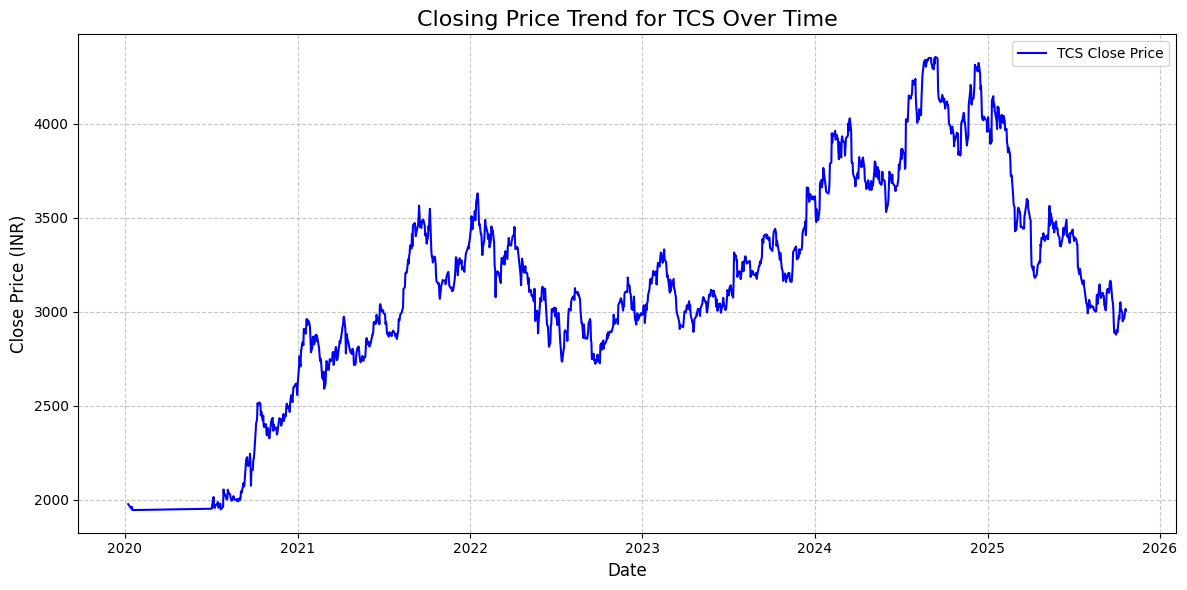

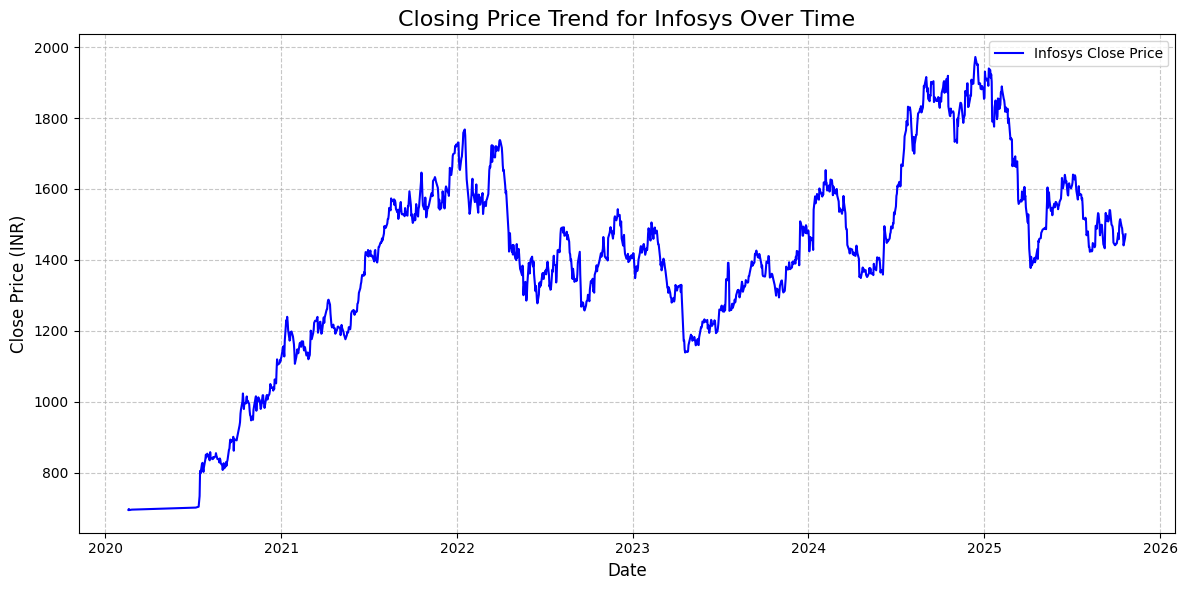

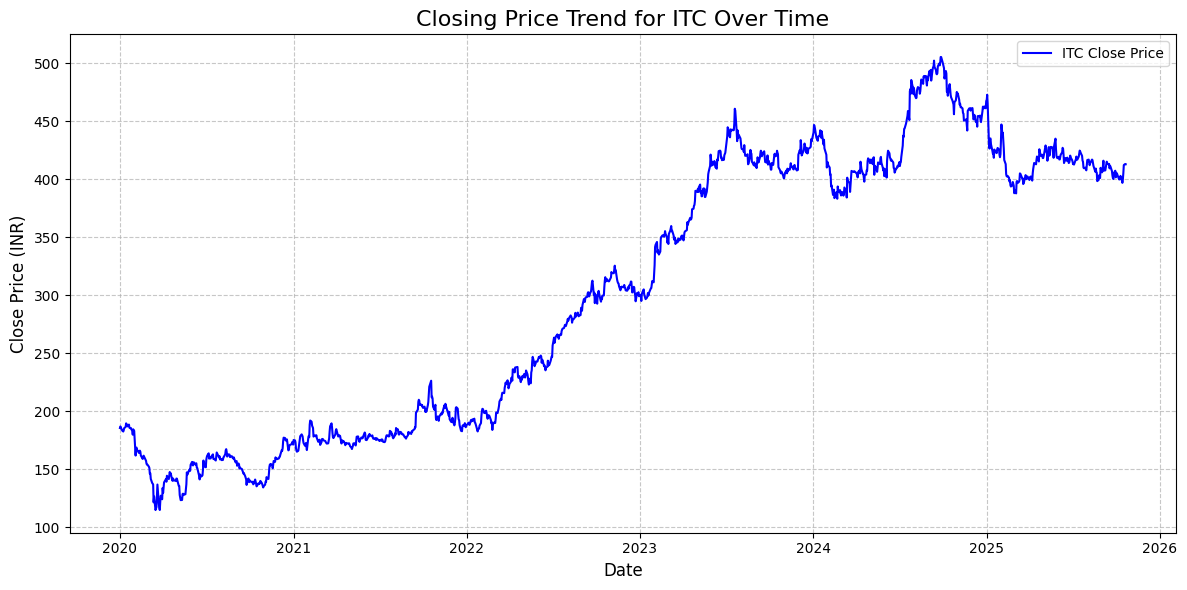

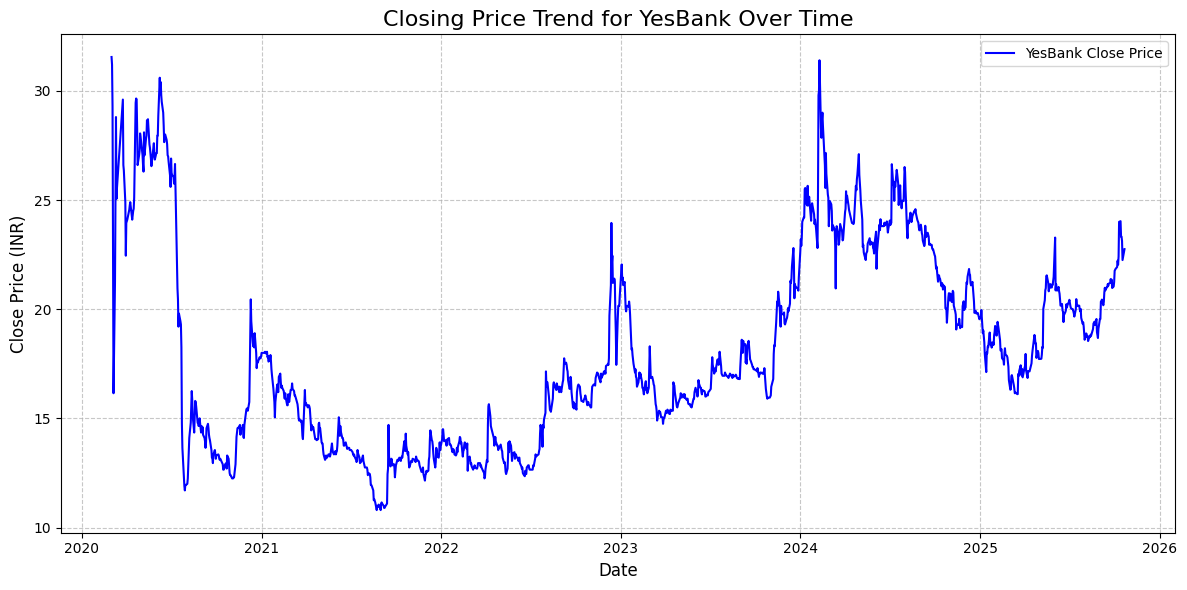

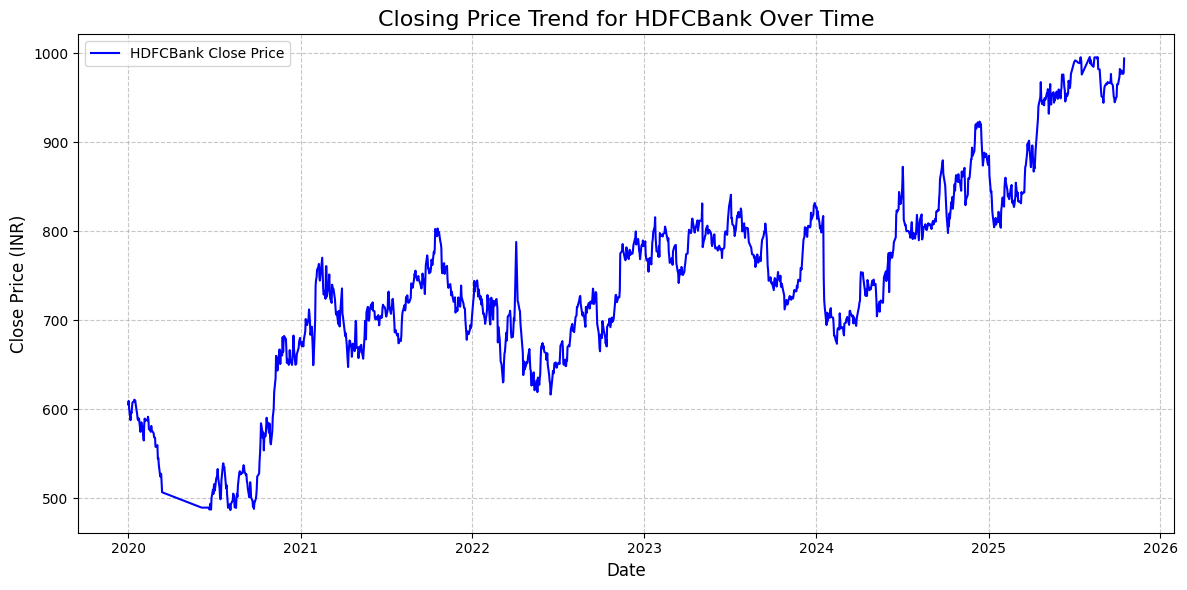

--- All closing price trend plots generated. ---


In [21]:
# --- Visualization: Closing Price Trend for All 5 Datasets ---

print("--- Generating Closing Price Trend Visualizations ---")

# Assuming processed_stock_data dictionary contains the clean dataframes

for company, df in processed_stock_data.items():

    # 1. Prepare Data
    # Set Date as the index for better plotting, although the previous code already used df["Date"] as the x-axis.
    # We will use the 'Date' column directly as the x-axis for simplicity and consistency with your request.

    # 2. Create the Plot
    plt.figure(figsize=(12, 6))

    # Plotting the Date vs. Close Price
    plt.plot(df["Date"], df["Close"], label=f"{company} Close Price", color="blue")

    # 3. Add Titles and Labels
    plt.title(f"Closing Price Trend for {company} Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price (INR)", fontsize=12)

    # 4. Final Touches
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

print("--- All closing price trend plots generated. ---")

In [22]:
# --- 1. Calculate 50-Day and 200-Day Moving Averages ---

print("--- Calculating 50-Day and 200-Day Moving Averages ---")

# Iterate through each DataFrame in the dictionary
for company, df in processed_stock_data.items():
    # Calculate 50-Day Moving Average
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Calculate 200-Day Moving Average
    df['MA200'] = df['Close'].rolling(window=200).mean()

    # Update the processed_stock_data dictionary
    processed_stock_data[company] = df

    print(f"✅ MA50 and MA200 calculated for {company}.")

--- Calculating 50-Day and 200-Day Moving Averages ---
✅ MA50 and MA200 calculated for TCS.
✅ MA50 and MA200 calculated for Infosys.
✅ MA50 and MA200 calculated for ITC.
✅ MA50 and MA200 calculated for YesBank.
✅ MA50 and MA200 calculated for HDFCBank.


In [24]:
ml_data = {}
models = {}

# --- CRITICAL PRE-STEP 1: Define RSI Calculation Function ---

def calculate_rsi(df, window=14):
    """Calculates the 14-day Relative Strength Index (RSI)."""
    # Requires 'Close' column
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# --- CRITICAL PRE-STEP 2: Calculate Features (MA and RSI) ---

print("--- Calculating MA and RSI Features ---")
# This assumes 'processed_stock_data' is defined and populated with your raw DataFrames
for company, df in processed_stock_data.items():
    if 'Close' not in df.columns:
        print(f"Skipping {company}: 'Close' price column is missing.")
        continue

    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = calculate_rsi(df)
    processed_stock_data[company] = df # Update the dictionary

# --- 3. Data Preparation, Splitting, and Scaling (Your Original Loop) ---

print("\n--- Data Preparation & Feature Scaling Confirmation ---")

for company, df in processed_stock_data.items():

    # Ensure data is clean (required for indicators like MA and RSI)
    # This step drops the first 50 or so rows which have NaN values for MA_50 or RSI
    df_clean = df.dropna(subset=['MA_20', 'MA_50', 'RSI'])

    if df_clean.empty:
        print(f"Skipping {company}: DataFrame is empty after cleaning. Not enough historical data.")
        continue

    # 1. Define X and y
    features = ['Open', 'High', 'Low', 'Volume', 'MA_20', 'MA_50', 'RSI']
    X = df_clean[features]
    y = df_clean['Close']

    # 2. Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        shuffle=False # Essential for time-series data
    )

    # 3. Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Store the results
    ml_data[company] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"✅ Data prepared for {company}. X_train shape: {X_train_scaled.shape}. Ready for training.")

print("\n--- Data Preparation Complete. ---")

--- Calculating MA and RSI Features ---

--- Data Preparation & Feature Scaling Confirmation ---
✅ Data prepared for TCS. X_train shape: (1010, 7). Ready for training.
✅ Data prepared for Infosys. X_train shape: (1011, 7). Ready for training.
✅ Data prepared for ITC. X_train shape: (1112, 7). Ready for training.
✅ Data prepared for YesBank. X_train shape: (1072, 7). Ready for training.
✅ Data prepared for HDFCBank. X_train shape: (1042, 7). Ready for training.

--- Data Preparation Complete. ---


In [25]:
# Dictionary to store trained LR models and predictions
models_lr = {}

print("--- 1. Training and Predicting with Linear Regression ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Initialize and Train Model
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)

    # Make Prediction
    y_pred_lr = lr.predict(X_test_scaled)

    # Store results
    models_lr[company] = {'model': lr, 'y_pred': y_pred_lr}

    print(f"✅ Linear Regression model trained and predicted for {company}.")

--- 1. Training and Predicting with Linear Regression ---
✅ Linear Regression model trained and predicted for TCS.
✅ Linear Regression model trained and predicted for Infosys.
✅ Linear Regression model trained and predicted for ITC.
✅ Linear Regression model trained and predicted for YesBank.
✅ Linear Regression model trained and predicted for HDFCBank.


In [26]:

# Dictionary to store trained DT models and predictions
models_dt = {}

print("\n--- 2. Training and Predicting with Decision Tree Regressor ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Initialize and Train Model
    # Using random_state for reproducibility
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train_scaled, y_train)

    # Make Prediction
    y_pred_dt = dt.predict(X_test_scaled)

    # Store results
    models_dt[company] = {'model': dt, 'y_pred': y_pred_dt}

    print(f"✅ Decision Tree model trained and predicted for {company}.")


--- 2. Training and Predicting with Decision Tree Regressor ---
✅ Decision Tree model trained and predicted for TCS.
✅ Decision Tree model trained and predicted for Infosys.
✅ Decision Tree model trained and predicted for ITC.
✅ Decision Tree model trained and predicted for YesBank.
✅ Decision Tree model trained and predicted for HDFCBank.


In [27]:
from sklearn.ensemble import RandomForestRegressor

# Dictionary to store trained RF models and predictions
models_rf = {}

print("\n--- 3. Training and Predicting with Random Forest Regressor ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Initialize and Train Model
    # n_estimators=100 is standard; n_jobs=-1 uses all available cores
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)

    # Make Prediction
    y_pred_rf = rf.predict(X_test_scaled)

    # Store results
    models_rf[company] = {'model': rf, 'y_pred': y_pred_rf}

    print(f"✅ Random Forest model trained and predicted for {company}.")


--- 3. Training and Predicting with Random Forest Regressor ---
✅ Random Forest model trained and predicted for TCS.
✅ Random Forest model trained and predicted for Infosys.
✅ Random Forest model trained and predicted for ITC.
✅ Random Forest model trained and predicted for YesBank.
✅ Random Forest model trained and predicted for HDFCBank.


In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Dictionaries to store the predictions
predictions_lr = {}
predictions_dt = {}
predictions_rf = {}

# Dictionary to hold all R2 scores
r2_scores = {}

print("--- Training Models and Making Predictions ---")

for company, data in ml_data.items():

    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']
    y_test = data['y_test'] # Actual values (used for evaluation)

    # 1. Linear Regression (LR)
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    predictions_lr[company] = lr.predict(X_test_scaled)

    # 2. Decision Tree (DT)
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train_scaled, y_train)
    predictions_dt[company] = dt.predict(X_test_scaled)

    # 3. Random Forest (RF)
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    predictions_rf[company] = rf.predict(X_test_scaled)

    print(f"✅ Models trained and predicted for {company}.")


# --- 4. Model Performance Evaluation (R-squared Score) ---

print("\n--- Model Performance Evaluation (R-squared Score) ---")

for company in ml_data.keys():

    # Get the true test values (253 samples)
    y_test = ml_data[company]['y_test']

    # Get predictions (now guaranteed to be 253 samples)
    y_pred_lr = predictions_lr[company]
    y_pred_dt = predictions_dt[company]
    y_pred_rf = predictions_rf[company]

    # Calculate R2 Score for each model
    r2_scores[company] = {
        'Linear Regression R2': r2_score(y_test, y_pred_lr),
        'Decision Tree R2': r2_score(y_test, y_pred_dt),
        'Random Forest R2': r2_score(y_test, y_pred_rf)
    }

# Display the results in a formatted table
df_r2 = pd.DataFrame(r2_scores).T

print("\nModel Comparison (R-squared Score on Test Data):")
print(df_r2.to_markdown(floatfmt=".6f"))

--- Training Models and Making Predictions ---
✅ Models trained and predicted for TCS.
✅ Models trained and predicted for Infosys.
✅ Models trained and predicted for ITC.
✅ Models trained and predicted for YesBank.
✅ Models trained and predicted for HDFCBank.

--- Model Performance Evaluation (R-squared Score) ---

Model Comparison (R-squared Score on Test Data):
|          |   Linear Regression R2 |   Decision Tree R2 |   Random Forest R2 |
|:---------|-----------------------:|-------------------:|-------------------:|
| TCS      |               0.998634 |           0.992875 |           0.996333 |
| Infosys  |               0.997907 |           0.988125 |           0.992327 |
| ITC      |               0.995969 |           0.975761 |           0.988678 |
| YesBank  |               0.993636 |           0.961009 |           0.982258 |
| HDFCBank |               0.997896 |          -0.544141 |          -0.371290 |


In [29]:

import datetime
print("\n--- Predicting Values for 25-12-2025 Using All Models ---")

# Dictionary to store all model predictions
future_predictions_all = {}

# Define target future date
target_date = datetime.date(2025, 12, 25)

for company, data in ml_data.items():
    # Retrieve scaled data
    X_train_scaled = data['X_train_scaled']
    X_test_scaled = data['X_test_scaled']
    y_train = data['y_train']

    # Use the latest available data as input for future prediction
    last_features = X_test_scaled[-1].reshape(1, -1)

    # --- 1️⃣ Linear Regression ---
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    pred_lr = lr.predict(last_features)[0]

    # --- 2️⃣ Decision Tree ---
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train_scaled, y_train)
    pred_dt = dt.predict(last_features)[0]

    # --- 3️⃣ Random Forest ---
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    pred_rf = rf.predict(last_features)[0]

    # Store predictions in a dictionary
    future_predictions_all[company] = {
        'Predicted Date': target_date,
        'Linear Regression Prediction': pred_lr,
        'Decision Tree Prediction': pred_dt,
        'Random Forest Prediction': pred_rf
    }

    # Print summary for each company
    print(f"\n📈 {company} ({target_date.strftime('%d-%m-%Y')})")
    print(f"  🔹 Linear Regression: {pred_lr:.2f}")
    print(f"  🔹 Decision Tree:     {pred_dt:.2f}")
    print(f"  🔹 Random Forest:     {pred_rf:.2f}")

# Convert to a DataFrame for better view
df_future_all = pd.DataFrame(future_predictions_all).T
print("\n--- Future Predictions for 25-12-2025 ---")
print(df_future_all.to_markdown(floatfmt=".2f"))



--- Predicting Values for 25-12-2025 Using All Models ---

📈 TCS (25-12-2025)
  🔹 Linear Regression: 3000.13
  🔹 Decision Tree:     3006.12
  🔹 Random Forest:     3015.45

📈 Infosys (25-12-2025)
  🔹 Linear Regression: 1475.83
  🔹 Decision Tree:     1470.78
  🔹 Random Forest:     1476.59

📈 ITC (25-12-2025)
  🔹 Linear Regression: 412.82
  🔹 Decision Tree:     412.19
  🔹 Random Forest:     413.68

📈 YesBank (25-12-2025)
  🔹 Linear Regression: 22.71
  🔹 Decision Tree:     23.00
  🔹 Random Forest:     22.82

📈 HDFCBank (25-12-2025)
  🔹 Linear Regression: 994.87
  🔹 Decision Tree:     852.06
  🔹 Random Forest:     858.11

--- Future Predictions for 25-12-2025 ---
|          | Predicted Date   |   Linear Regression Prediction |   Decision Tree Prediction |   Random Forest Prediction |
|:---------|:-----------------|-------------------------------:|---------------------------:|---------------------------:|
| TCS      | 2025-12-25       |                        3000.13 |                    30